# Import RPB model along with other utility functions

In [1]:
from RPB_model import *

expression symbols from pyomo.core.expr  (deprecated in 6.6.2.dev0) (called
from <frozen importlib._bootstrap>:241)


# Creating model for a single side/section of the RPB

In [2]:
# Create model instance. Currently, mode can be either "adsorption" or "desorption" which sets the initial values and boundary conditions for each case.
# m=RPB_model(mode="adsorption", gas_flow_direction=1)
# or
m=RPB_model(mode="desorption", gas_flow_direction=-1)

# Custom initialization routine. Uses block initialization function.
single_section_init(m)

DOF = 0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See

In [3]:
# Some various utility functions to check model performance
evaluate_MB_error(m)

print(f'CO2 Capture = {m.CO2_capture():.3}')

N2 error = -2.22e-14 %
CO2 error = -0.144 %
H2O error = 0.0 %
CO2 Capture = -1.06e+04


In [ ]:
# scaling functions

# check_scaling(m)

# jac, variables, constraints = scaling_script(m)

In [ ]:
plotting(m)

# Creating a full RPB model

From scratch

In [5]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [6]:
# initialize using BlockTriangularizationInitializer() with a list of values for initialization factors within the models
init_routine_1(RPB, homotopy_points=[0.01, 0.1, 0.25, 0.5, 0.75, 1])

DOF = 0
Ipopt 3.13.2: max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        com

From a previous solution

In [9]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

# load a previous solution and solve
from_json(RPB, fname="base case solution 012424.json.gz", gz=True)

solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
}
solver.solve(RPB, tee=True).write()

component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: max_iter=1000
bound_push=1e-22
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material r

In [10]:
report(RPB)

,Value,Doc,Fixed,Lower Bound,Upper Bound
ads.L,3.000000,Bed Length [m],True,0.1,10.001
ads.D,10.000000,Bed diameter [m],True,None,None
ads.w_rpm,1.000000,bed rotational speed [revolutions/min],True,0.00001,2
ads.theta,0.750000,Fraction of bed [-],True,0.01,0.99
des.theta,0.250000,Fraction of bed [-],False,0.01,0.99
ads.P_in,1.025649,Inlet flue gas pressure [bar],True,1,1.5
ads.P_out,1.013250,Outlet adsorber pressure [bar],True,0.99,1.2
ads.F_in,130.375215,Inlet adsorber gas flow [mol/s],False,0,None
ads.Tg_in,363.000000,Inlet flue gas temperature [K],True,None,None
ads.Tx,363.000000,"heat exchange fluid temperature, constant [K]",True,None,None


In [11]:
evaluate_MB_error(RPB.ads)
print(' ')
evaluate_MB_error(RPB.des)

N2 error = 2.2e-12 %
CO2 error = 0.0552 %
H2O error = -8.28e-12 %
 
N2 error = -2.72e-10 %
CO2 error = 0.0561 %
H2O error = 2.22e-14 %


In [ ]:
# different scaling functions

# check_scaling(RPB)

# jac, variables, constraints = scaling_script(RPB)

# Optimization

In [ ]:
# starting from initialized model. Change design to fix capture by freeing up inlet adsorber pressure

RPB.ads.P_in.unfix()
RPB.ads.CO2_capture.fix(0.95)

solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    # "halt_on_ampl_error": "yes",
}
solver.solve(RPB, tee=True).write()

In [ ]:
# create regularization parameter for the objective function
RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@RPB.Expression()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

RPB.objective = Objective(expr=RPB.obj)

RPB.objective.pprint()

In [ ]:
# set bounds for decision variables
RPB.ads.L.setlb(0.01)
RPB.ads.L.setub(40)
RPB.des.L.setlb(0.01)
RPB.des.L.setub(40)
RPB.ads.L.pprint()

In [ ]:
RPB.ads.Tx.setlb(25+273)
RPB.ads.Tx.setub(95+273)
RPB.ads.Tx.pprint()

In [ ]:
RPB.des.Tx.setlb(100+273)
RPB.des.Tx.setub(160+273)
RPB.des.Tx.pprint()

In [ ]:
RPB.ads.P_in.setub(1.5)
RPB.ads.P_in.pprint()
RPB.ads.P.setub(1.5)

In [ ]:
RPB.des.P_in.setub(1.5)
RPB.des.P_in.setlb(1.01325)
RPB.des.P.setub(1.5)
RPB.des.P_in.pprint()

In [ ]:
RPB.ads.w_rpm.setlb(0.00001)
RPB.ads.w_rpm.setub(0.005)
RPB.ads.w_rpm.pprint()

In [ ]:
# free up decision variables (keep des.Tx fixed for first run the free up later)
RPB.ads.L.unfix()
RPB.ads.theta.unfix()
RPB.des.P_in.unfix()
RPB.ads.Tx.unfix()
RPB.des.Tx.unfix()
RPB.ads.w_rpm.unfix()

In [ ]:
degrees_of_freedom(RPB)

In [ ]:
RPB.ads.w_rpm.unfix()

In [ ]:
# solve using conopt thorugh gams
results = SolverFactory("gams").solve(
    RPB,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

In [ ]:
# or solve using ipopt
# solver = SolverFactory("ipopt")
# solver.options = {
#     "max_iter": 1000,
#     "bound_push": 1e-8,
#     # "halt_on_ampl_error": "yes",
#     "tol": 1e-4,
#     "max_cpu_time": 5*60,
#     # "mu_strategy": "adaptive",
# }
# solver.solve(RPB, tee=True).write()

In [ ]:
results_df = report(RPB)
results_df

In [ ]:
evaluate_MB_error(RPB.ads)
print(' ')
evaluate_MB_error(RPB.des)

In [ ]:
# custom function using degeneracy hunter. Mainly to see if any variables are pushing their bounds
degen_hunter(RPB)

start from previous optimized case

In [14]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [15]:
# create regularization parameter for the objective function
RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@RPB.Expression()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

RPB.objective = Objective(expr=RPB.obj)

RPB.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize :        obj


In [16]:
# set bounds for decision variables
RPB.ads.L.setlb(0.01)
RPB.ads.L.setub(40)
RPB.des.L.setlb(0.01)
RPB.des.L.setub(40)
RPB.ads.L.pprint()

L : Bed Length [m]
    Size=1, Index=None, Units=m
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :  0.01 :     3 :    40 :  True : False :  Reals


In [17]:
RPB.ads.Tx.setlb(25+273)
RPB.ads.Tx.setub(95+273)
RPB.ads.Tx.pprint()

Tx : heat exchange fluid temperature, constant [K]
    Size=1, Index=None, Units=K
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :   298 :   363 :   368 :  True : False :  Reals


In [18]:
RPB.des.Tx.setlb(100+273)
RPB.des.Tx.setub(160+273)
RPB.des.Tx.pprint()

Tx : heat exchange fluid temperature, constant [K]
    Size=1, Index=None, Units=K
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None :   373 :   393 :   433 :  True : False :  Reals


In [19]:
RPB.ads.P_in.setub(1.5)
RPB.ads.P_in.pprint()
RPB.ads.P.setub(1.5)

P_in : Inlet flue gas pressure [bar]
    Size=1, Index=None, Units=bar
    Key  : Lower : Value    : Upper : Fixed : Stale : Domain
    None :     1 : 1.025649 :   1.5 :  True : False :  Reals


In [20]:
RPB.des.P_in.setub(1.5)
RPB.des.P_in.setlb(1.01325)
RPB.des.P.setub(1.5)
RPB.des.P_in.pprint()

P_in : Inlet flue gas pressure [bar]
    Size=1, Index=None, Units=bar
    Key  : Lower   : Value : Upper : Fixed : Stale : Domain
    None : 1.01325 :   1.1 :   1.5 :  True : False :  Reals


In [21]:
RPB.ads.w_rpm.setlb(0.00001)
RPB.ads.w_rpm.setub(0.005)
RPB.ads.w_rpm.pprint()

w_rpm : bed rotational speed [revolutions/min]
    Size=1, Index=None, Units=turn/min
    Key  : Lower : Value : Upper : Fixed : Stale : Domain
    None : 1e-05 :     1 : 0.005 :  True : False :  Reals


In [22]:
# load a previous solution and solve
from_json(RPB, fname="opt solution 012424.json.gz", gz=True)

{'etime_load_file': 0.13667917251586914,
 'etime_read_dict': 0.33664965629577637,
 'etime_read_suffixes': 0.022780656814575195}

In [23]:
# free up decision variables (keep des.Tx fixed for first run the free up later)
RPB.ads.L.unfix()
RPB.ads.theta.unfix()
RPB.des.P_in.unfix()
RPB.ads.Tx.unfix()
RPB.des.Tx.unfix()
RPB.ads.w_rpm.unfix()

In [24]:
degrees_of_freedom(RPB)

6

In [26]:
# solve using conopt thorugh gams
results = SolverFactory("gams").solve(
    RPB,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

--- Job model.gms Start 01/24/24 14:02:00 40.4.0 d540b52e WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\40\gmsprmNT.txt
--- GAMS Parameters defined
    Input "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\model.gms"
    Output "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\output.lst"
    ScrDir "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\225l\"
    SysDir C:\GAMS\40\
    CurDir "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\"
    LogOption 3
Licensee: Medium MUD - 10 User License                   G211229|0002CN-GEN
          U.S. Department of Energy, National Energy Technology LaborDC9138
          C:\Users\hughesr\Documents\GAMS\gamslice.txt
          License Admin: Anthony P. Burgard, anthony.burgard@netl.doe.gov  
Processor information: 1 socket(s), 8 core(s), and 16 thread(s) available


In [25]:
degen_hunter(RPB)

component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
 
No constraints with residuals larger than 1e-06 !
 
Variables within 1e-06 (absolute) of their bounds:
variable	lower	value	upper
des.Tx 		 373 	 433.0 	 433


pareto front generation

In [27]:
# list of alpha values to use in the objective function
alpha_list=[
    0.0001,
    0.001,
    0.005,
    0.01,
    0.02,
    0.05,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.925,
    0.95,
    0.975,
    0.99,
    0.999,
]

In [28]:
# optimize for every value and store the results
E = []
P = []

for j in alpha_list:
    RPB.alpha_obj = j

    results = SolverFactory("gams").solve(
        RPB,
        tee=True,
        keepfiles=True,
        solver="conopt4",
        tmpdir="temp",
        add_options=["gams_model.optfile=1;"],
    )

    print(f'alpha = {j}, E={RPB.energy_requirement()}, P={RPB.productivity()}')

    E.append(RPB.energy_requirement())
    P.append(RPB.productivity())


--- Job model.gms Start 01/24/24 14:03:47 40.4.0 d540b52e WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\40\gmsprmNT.txt
--- GAMS Parameters defined
    Input "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\model.gms"
    Output "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\output.lst"
    ScrDir "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\225l\"
    SysDir C:\GAMS\40\
    CurDir "c:\Users\hughesr\NETL\CCSI\fixed bed adsorption\fixed_bed_adsorption\Rotary packed bed\temp\"
    LogOption 3
Licensee: Medium MUD - 10 User License                   G211229|0002CN-GEN
          U.S. Department of Energy, National Energy Technology LaborDC9138
          C:\Users\hughesr\Documents\GAMS\gamslice.txt
          License Admin: Anthony P. Burgard, anthony.burgard@netl.doe.gov  
Processor information: 1 socket(s), 8 core(s), and 16 thread(s) available


In [29]:
pd.DataFrame({'alpha':alpha_list,'E':E,'P':P})

,alpha,E,P
0,0.0001,15.156435,11.017239
1,0.0010,15.156373,11.017239
2,0.0050,15.156094,11.017238
3,0.0100,15.155749,11.017235
4,0.0200,15.155069,11.017225
5,0.0500,11.889904,10.910480
6,0.1000,9.175358,10.688287
7,0.2000,6.777397,10.289676
8,0.3000,5.967225,10.029823
9,0.4000,5.433812,9.746218


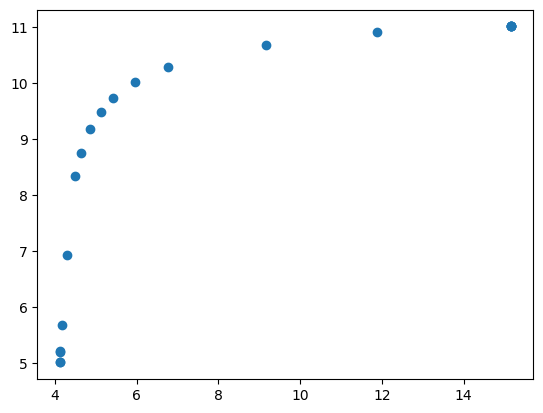

In [30]:
plt.scatter(E,P)

# Plotting

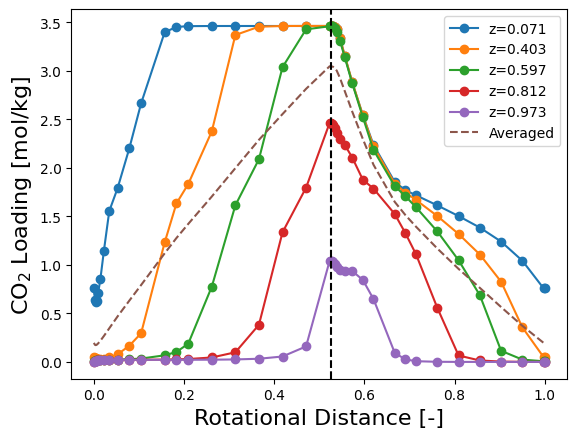

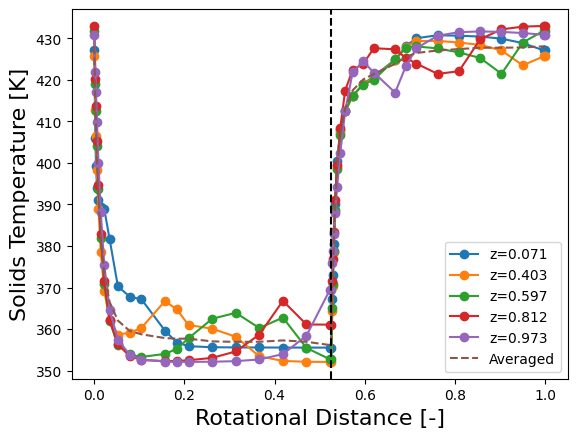

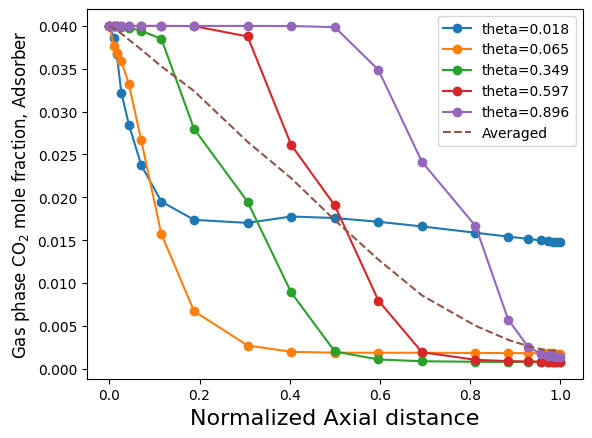

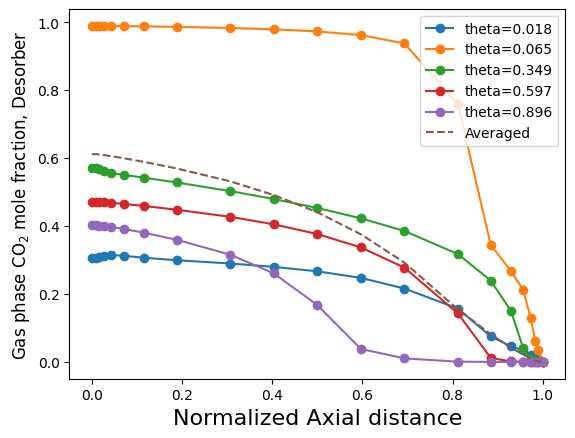

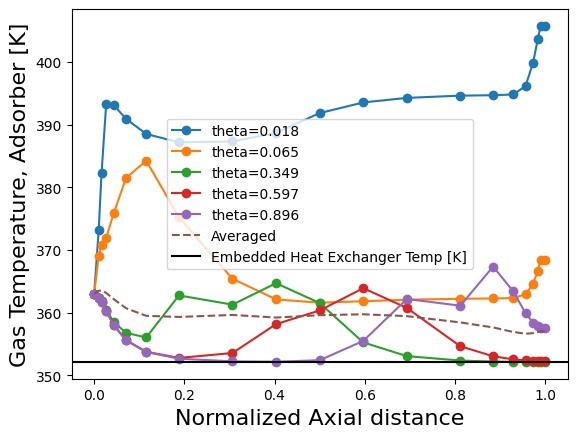

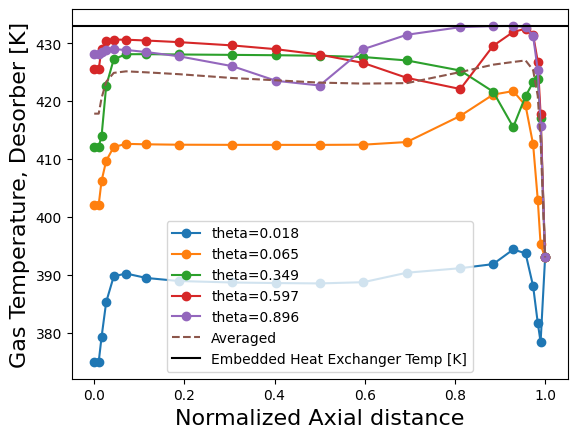

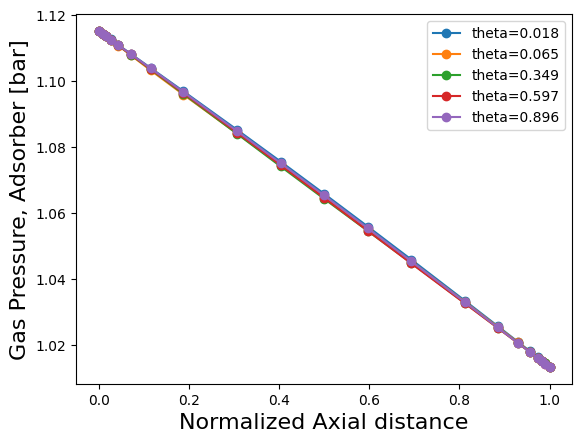

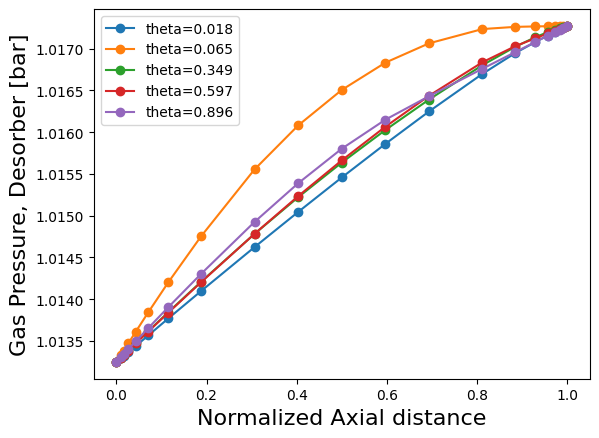

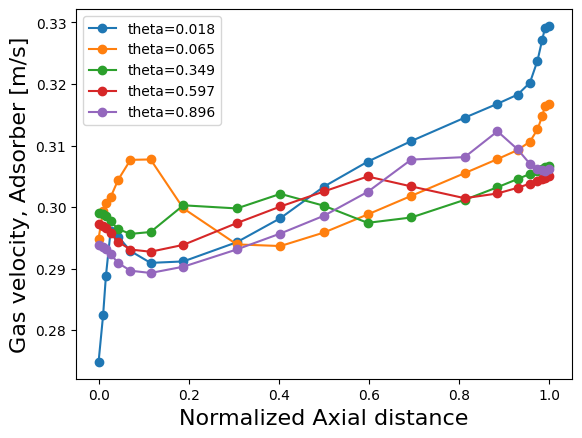

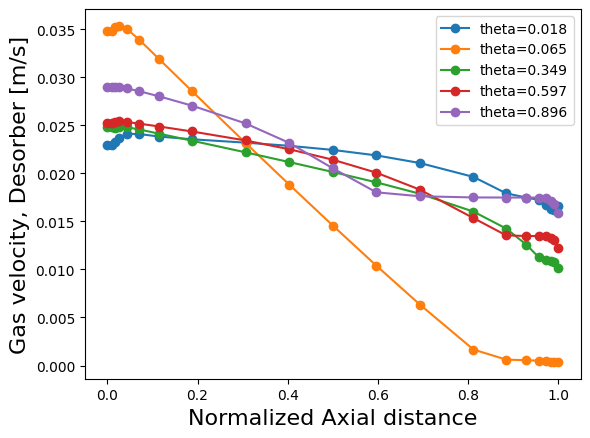

In [31]:
full_contactor_plotting(RPB)

# Save Model

In [8]:
# save model
to_json(RPB, fname="base case solution 012424.json.gz", gz=True, human_read=False)